Title

Description

Importing packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing data into pandas DataFrame.

In [2]:
df = pd.read_csv(r"fullDataFinal.csv", index_col=0)
df.columns = df.columns.str.strip()
df.sample(5)

,fire_size_class,latitude,longitude,discovery_month,weekday,Vegetation,remoteness,elevation,Temp,Wind,Humidity,Precipitation
8948,C,33.053140,-85.843670,May,False,Broadleaf Forest,0.169661,223.0,20.837744,2.455100,69.398060,32.000000
22745,B,35.029240,-82.369740,Mar,True,Rock,0.137215,328.0,9.642178,4.091909,63.635880,69.866667
13609,B,31.897800,-89.246400,Sep,True,Shrubland,0.201400,107.0,23.757885,2.183852,71.022795,29.566667
33727,G,35.283300,-119.517600,Aug,True,Rock,0.092976,410.0,28.774405,3.102835,38.998805,0.000000
11805,B,34.603104,-82.875366,Apr,True,Broadleaf Forest,0.141991,213.0,19.184859,2.074433,64.080438,23.133333


Separate target variable (fire_size_class) from predictor variables.

In [3]:
dfTarget = df["fire_size_class"]
dfPredictor = df[["latitude", "longitude", "discovery_month", "weekday", "Vegetation", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]

Before doing anything, let's check the distribution of our data by plotting a histogram

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'remoteness'}>],
       [<AxesSubplot:title={'center':'elevation'}>,
        <AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'Wind'}>],
       [<AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'Precipitation'}>, <AxesSubplot:>]],
      dtype=object)

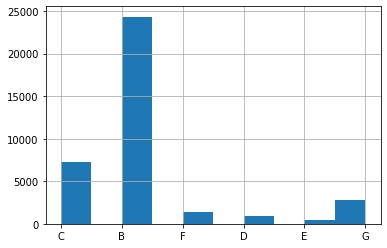

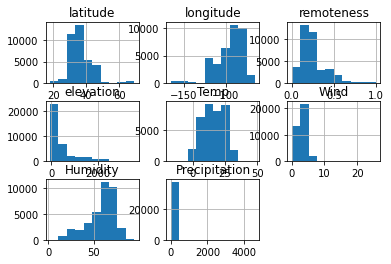

In [4]:
dfTarget.hist()
dfPredictor.hist()

From the first histogram we can see that the "B" class is *way* overrepresented in our data and there is an imbalance.

In order to deal with this, I chose to undersample the B class.



Changing categorical variables into one-hot encoded ones.

In [5]:
# First let's do fire_size_class
dfTarget = pd.concat([dfTarget, pd.get_dummies(dfTarget)], axis=1)  # use get_dummies and concatenate the result to dfTarget
dfTarget.drop(["fire_size_class"], axis=1, inplace=True)  # and remove the old column
dfTarget.sample(5)

,B,C,D,E,F,G
28532,0,1,0,0,0,0
1025,1,0,0,0,0,0
48,0,1,0,0,0,0
25517,1,0,0,0,0,0
10870,1,0,0,0,0,0


In [7]:
# Now Vegetation
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["Vegetation"], prefix="Veg", prefix_sep=" ")], axis=1)
dfPredictor.drop(["Vegetation"], axis=1, inplace=True)

# And discovery_month
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["discovery_month"])], axis=1)
dfPredictor.drop(["discovery_month"], axis=1, inplace=True)

# And weekday
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["weekday"])], axis=1)
dfPredictor.drop(["weekday"], axis=1, inplace=True)
dfPredictor.rename(columns={False:"is_weekend", True:"is_weekday"}, inplace=True)
dfPredictor.sample(5)

KeyError: 'Vegetation'

Scaling numerical data to 0-1 range.

In [8]:
from sklearn.preprocessing import MinMaxScaler

dfPredictorScaled = pd.DataFrame(MinMaxScaler().fit_transform(dfPredictor[["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]), columns=["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"])
# dfPredictorScaled.sample(5)

dfPredictor = dfPredictor.assign(**dfPredictorScaled.to_dict(orient="series"))  # replace the columns of the old df with the ones from the new one
dfPredictor.sample(5)

,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
9095,0.299647,0.692166,0.264005,0.074602,0.692611,0.100463,0.663074,0.000000,1,0,...,0,1,0,0,0,0,0,0,0,1
13932,0.390666,0.725470,0.230234,0.108064,0.430059,0.129038,0.561608,0.000000,0,0,...,0,0,0,1,0,0,0,0,1,0
34341,0.471828,0.512911,0.034004,0.460505,0.592875,0.102382,0.405660,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,1
4356,0.346791,0.803639,0.160317,0.179100,0.458769,0.063185,0.725256,0.010027,0,0,...,0,0,0,0,0,1,0,0,0,1
7771,0.260124,0.822042,0.146867,0.041690,0.441071,0.117023,0.642711,0.006308,0,0,...,0,0,0,0,0,0,0,0,0,1


Make a correlation matrix

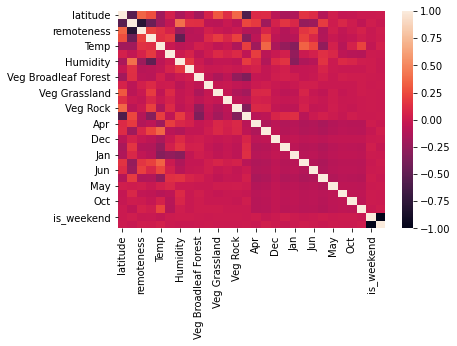

In [9]:
import seaborn as sn

corrMatrix = dfPredictor.corr()
sn.heatmap(corrMatrix)
plt.show()

Train-test split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfPredictor, dfTarget, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)

(33522, 28)
(33522, 6)


In order to fix the distribution of the data when training, we want to change it (in the training set only though).

First, I tried randomly undersampling the data, however that made the training set too small (down to 2.6k samples total). The results were abysmal, with basically every model getting around a 2% accuracy on the test set.

This is the code to do this, in case you want to (but you shouldn't).

    from imblearn.under_sampling import RandomUnderSampler

    rus = RandomUnderSampler()
    X_train, y_train = rus.fit_resample(X_train, y_train.values)

    print(X_train.shape)
    print(y_train.shape)

    y_train = pd.DataFrame(y_train)

Next, I tried the opposite approach -- random *over*sampling.

Here, examples from the smaller classes are picked randomly and repeated in the dataset.

This made the training set massive, at 130k+ samples, but it also made training take forever and didn't achieve great results.

    from imblearn.over_sampling import RandomOverSampler

    ros = RandomOverSampler()
    X_train, y_train = ros.fit_resample(X_train, y_train.values)

    print(X_train.shape)
    print(y_train.shape)

    y_train = pd.DataFrame(y_train)

In [11]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train.values)
y_train = pd.DataFrame(y_train)

d:\pycharmprojects\thesis\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=0)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train.values)
y_train = pd.DataFrame(y_train)

In [ ]:
X_train.hist()
y_train.hist()

In [ ]:
X_train.hist()
y_train.hist()

X_train.hist()
y_train.hist()

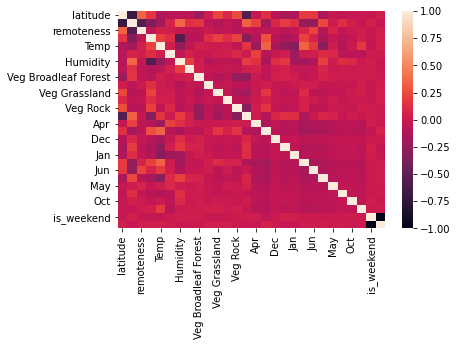

In [14]:
import seaborn as sn

corrMatrix = X_train.corr()
sn.heatmap(corrMatrix)
plt.show()

Training models, each in a cell (?)

* Dummy classifier
* K-Nearest Neighbour (KNN)
* Naïve Bayes (NB)
* Support Vector Machine (SVM)
* Decision Tree (DT)
* Random Forest (RF)
* Gradient Boosted Trees (GBT)
* Multi-Layered Perceptron (MLP)
* Artificial Neural Network (ANN)

Evaluation with confusion matrix, F1 score, etc

### Dummy classifier

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(X_train, y_train)
training_accuracy = dummy_clf.score(X_train, y_train)
test_accuracy = dummy_clf.score(X_test, y_test)
print(f"Training accuracy: {training_accuracy}")  # 0.6537796074219915
print(f"Test accuracy: {test_accuracy}")  # 0.6502013422818792


Training accuracy: 0.06763703838900043
Test accuracy: 0.06711409395973154


### KNN

Trained in in 4358.5422 seconds


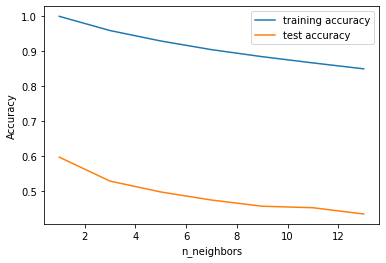

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(2, 15, 2)}

grid_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid, cv=5)
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))


? seems to be the best on our test set. Let's train that model and save it.

In [60]:
clf = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
clf.fit(X_train, y_train)

training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print("Number of neighbors: 9")
print(f"\nTraining accuracy: {training_accuracy}")  # 0.7298490543523656
print(f"\nTest accuracy: {test_accuracy}")  # 0.6934228187919463

Number of neighbors: 9

Training accuracy: 0.2018140589569161

Test accuracy: 0.1312751677852349


### Naive Bayes

In [18]:
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

# train a Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
multi_gnb = MultiOutputClassifier(gnb, n_jobs=-1)
multi_gnb.fit(X_train, y_train)
print(f"GaussianNB train score: {multi_gnb.score(X_train, y_train)}")  # 0.21296462024938845
print(f"GaussianNB test score: {multi_gnb.score(X_test, y_test)}")  # 0.21986577181208053
print("\n")


GaussianNB train score: 0.025650970371722332
GaussianNB test score: 0.01825503355704698




### Support Vector Machine

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

param_grid = {'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1]}

grid_search = GridSearchCV(MultiOutputClassifier(SVC(), n_jobs=-1), param_grid, cv=5)
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best seems to be with C = ?

Now lets train the final SVM

In [63]:
svm = SVC(C = 0.25)
multi_svm = MultiOutputClassifier(svm, n_jobs=-1)
multi_svm.fit(X_train, y_train)

print(f"Kernel SVM train score: {multi_svm.score(X_train, y_train)}")  # 0.7018077680329335
print(f"Kernel SVM test score: {multi_svm.score(X_test, y_test)}")  # 0.6977181208053691
print("\n")

Kernel SVM train score: 0.007558578987150416
Kernel SVM test score: 0.0018791946308724832




### Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 40]}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, )
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

[0.         0.01928166 0.02344045 0.03854549 0.03438813 0.03892571
 0.05328601 0.0638706  0.07975318 0.09714021 0.11680066 0.12058351
 0.12700717 0.13796983 0.13419125 0.13721654 0.13381175]
Test set score: 0.32


Best max_depth is 5 -->  0.72060144

In [65]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

print(f"Decision Tree train score: {dt.score(X_train, y_train)}")  # 0.7240618101545254
print(f"Decision Tree test score: {dt.score(X_test, y_test)}")  # 0.7103355704697987
print("\n")

Decision Tree train score: 0.20408163265306123
Decision Tree test score: 0.15409395973154363




### Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':[2,4,8,10,11,12,13,14,15,16,20,30,40]}

grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1, warm_start=True), param_grid, cv=5)
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

[0.         0.01436673 0.02607697 0.02909869 0.03060884 0.03061027
 0.03098691 0.03136498 0.03249848 0.03363341 0.0340122  0.0336327
 0.03552377]
Test set score: 0.17


Best seems to be with max_depth=12

In [67]:
rf = RandomForestClassifier(max_depth=12, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Random Forest train score: {rf.score(X_train, y_train)}")  # 0.7210786945886284
print(f"Random Forest test score: {rf.score(X_test, y_test)}")  # 0.6877852348993289
print("\n")


Random Forest train score: 0.5600907029478458
Random Forest test score: 0.12590604026845637




### Gradient Boosted Trees (GBT)

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

param_grid = {'estimator__max_depth':[2,4,8,16,30,40], 'estimator__loss':['deviance', 'exponential']}

gbt = MultiOutputClassifier(GradientBoostingClassifier(verbose=0, warm_start=True))
grid_search = GridSearchCV(gbt, param_grid, cv=5)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print('Best parameters found:\n', grid_search.best_params_)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

d:\pycharmprojects\thesis\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\pycharmprojects\thesis\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\pycharmprojects\thesis\lib\site-packages\sklearn\multioutput.py", line 368, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "d:\pycharmprojects\thesis\lib\site-packages\sklearn\multioutput.py", line 178, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "d:\pycharmprojects\thesis\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "d:\pycharmprojects\thesis\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "d:\pych

[nan nan nan nan nan nan nan nan nan nan nan nan]
Best parameters found:
 {'estimator__loss': 'deviance', 'estimator__max_depth': 2}
Test set score: 0.12


### Multi-Layered Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(5, 10, 5), (15, 30, 15), (5, 10, 10, 5), (15, 30, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

grid_search = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=5)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

y_true, y_pred = y_test , grid_search.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

print('Best parameters found:\n', grid_search.best_params_)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))


d:\pycharmprojects\thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
